In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

source_folder = '/content/drive/MyDrive/CS5242/frames/test'
destination_folder = '/content/test'

shutil.copytree(source_folder, destination_folder)

'/content/test'

In [ ]:
source_folder = '/content/drive/MyDrive/CS5242/frames/train'
destination_folder = '/content/train'
shutil.copytree(source_folder, destination_folder)

'/content/train'

# Import Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras import layers, models

# Hyperparameter

In [ ]:
batch_size = 32
img_height = 384
img_width = 384

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# Prepare dataset

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 21414 files belonging to 2 classes.
Using 14990 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 21414 files belonging to 2 classes.
Using 6424 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['norm', 'weap']


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 4053 files belonging to 2 classes.


# Show dataset

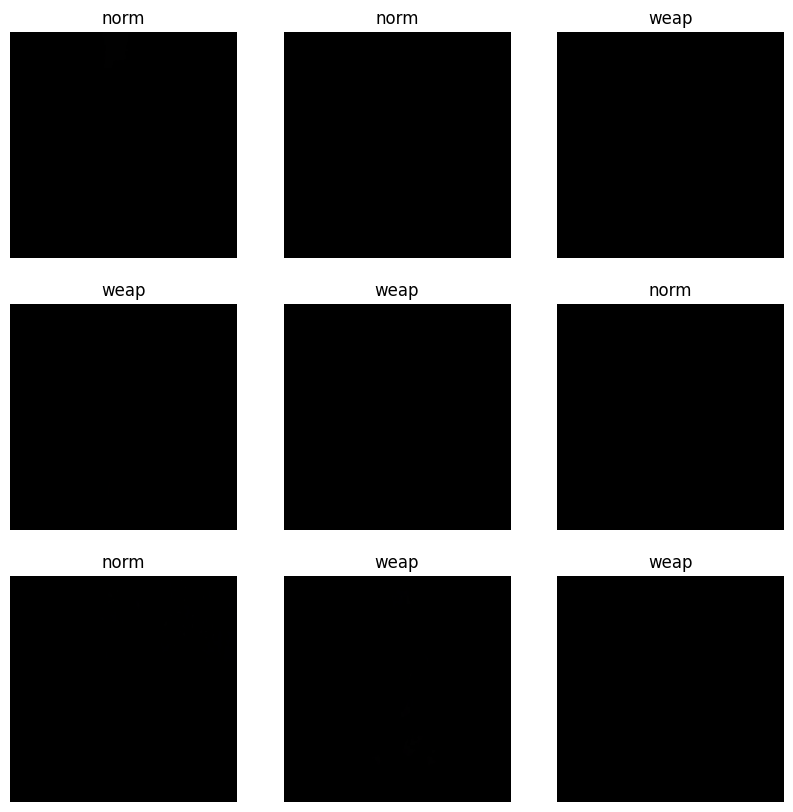

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Check shape of images

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 384, 384, 3)
(32,)


# Data Augmentation

Including random flipping, random rotation and randomzoom.

In [ ]:
num_classes = len(class_names)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
      input_shape=(img_height, img_width, 3)),
    layers.RandomTranslation(
      height_factor=(-0.2,0.3),
      width_factor=(-0.2,0.3),
      fill_mode='reflect',
      interpolation='bilinear',
      seed=33),
    layers.RandomCrop(384, 384),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
  ]
)

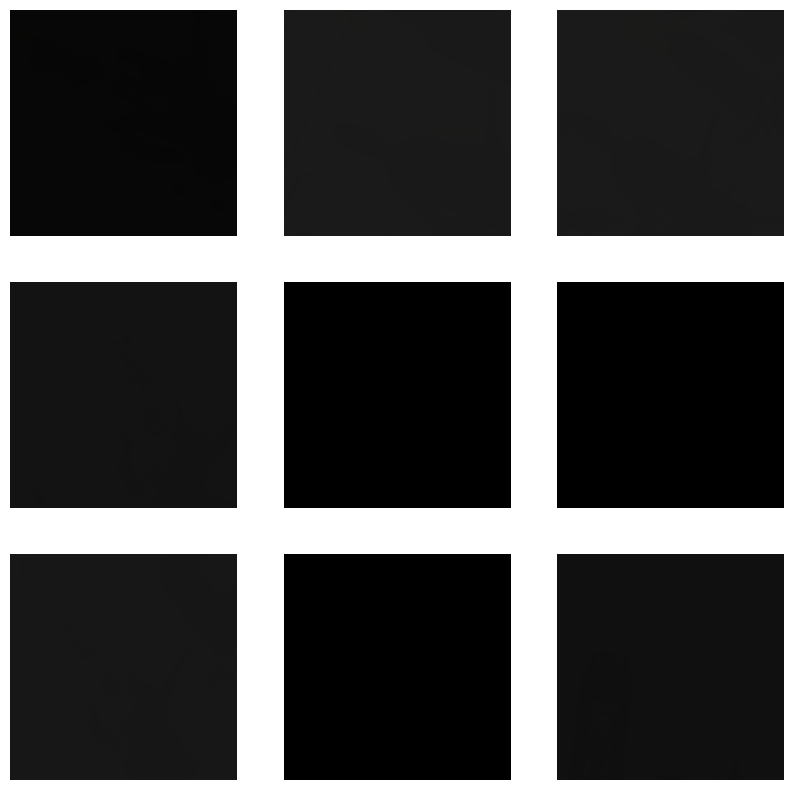

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(50):  #take 1 batch
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))  #first picture in that batch
    plt.axis("off")

## Normalization

In [ ]:
# Normalize
def normalize(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

# Define Model

Added several dropout layers and reduced numbers of residual block

In [ ]:
def resnet_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def resnet18(input_shape=(384, 384, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)
    inputs = data_augmentation(inputs)  # add data augmentation
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = tf.keras.layers.Dropout(0.1)(x) # add dropout layer

    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)
    x = tf.keras.layers.Dropout(0.1)(x) # add dropout layer

    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes)(x)

    model = models.Model(inputs=inputs, outputs=x)

    return model
model_resnet18_new = resnet18(input_shape=(384, 384, 3), num_classes=2)
model_resnet18_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_resnet18_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 112, 112, 64  9408        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 112, 112, 64  256        ['conv2d_15[1][0]']              
 ormalization)                  )                                                           

## Show Model Architecture

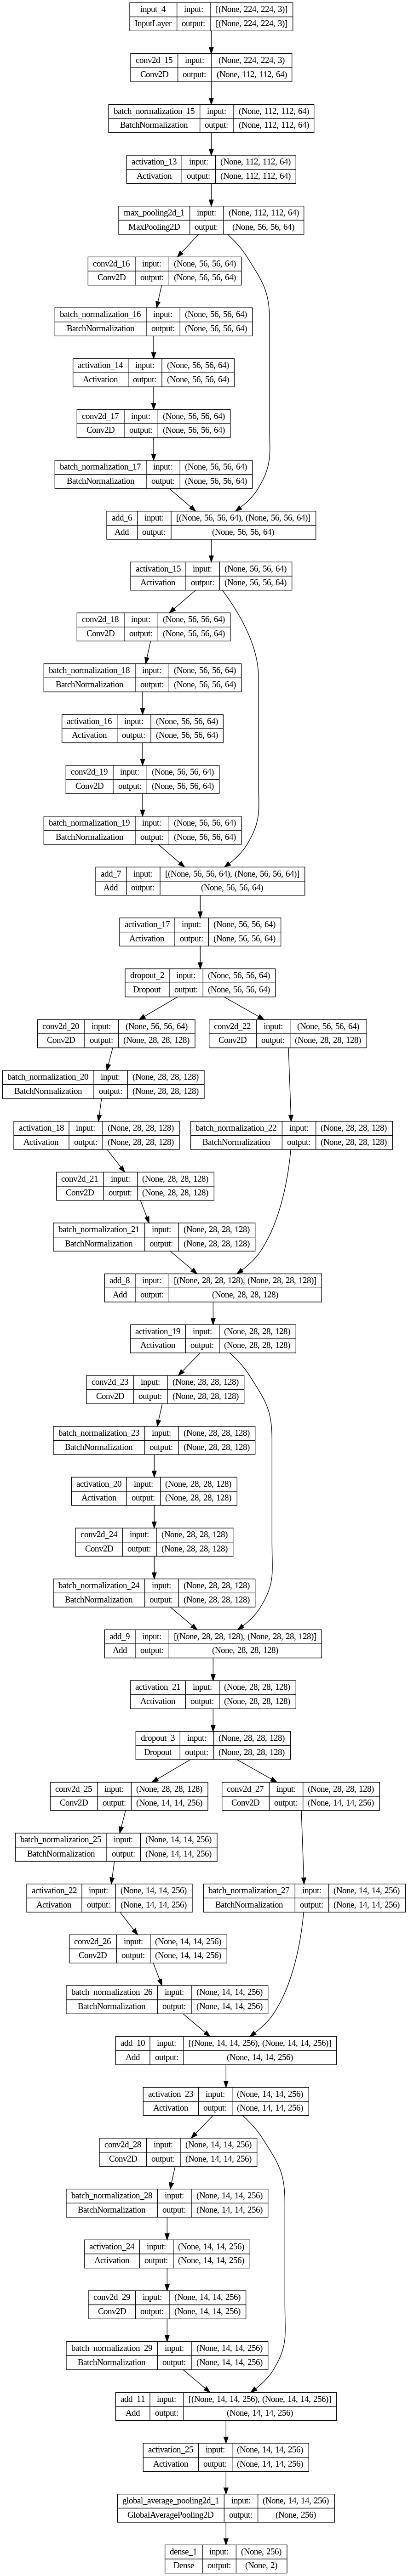

In [ ]:
tf.keras.utils.plot_model(model_resnet18_new,show_shapes=True)

## Training

Use learning rate scheduler, learning rate becomes smaller as epochs increases.

In [ ]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 4:
        lr *= 1e-1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
history = model_resnet18_new.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[lr_scheduler])

Epoch 1/30


ValueError: ignored

In [ ]:
model_resnet18_new.evaluate(test_ds)[1]

127/127 [==============================] - 148s 1s/step - loss: 0.9100 - accuracy: 0.6817


0.6817172169685364

Accuracy on testing dataset increased comparing to original Resnet architecture.

## Save model

In [ ]:
model_resnet18_new.save("Resnet18_update.h5")

## Check Filter

In [ ]:
i = 0
layer_indices = []
layer_names = []
for layer in model_resnet18_new.layers:
	# check for convolutional layer
  if 'conv' not in layer.name:
    i += 1
    continue
	# summarize output shape
  print(i, layer.name, layer.output.shape)
  layer_indices.append(i)
  layer_names.append(layer.name)
  i += 1

1 conv2d (None, 112, 112, 64)
5 conv2d_1 (None, 56, 56, 64)
8 conv2d_2 (None, 56, 56, 64)
12 conv2d_3 (None, 56, 56, 64)
15 conv2d_4 (None, 56, 56, 64)
20 conv2d_5 (None, 28, 28, 128)
23 conv2d_6 (None, 28, 28, 128)
24 conv2d_7 (None, 28, 28, 128)
29 conv2d_8 (None, 28, 28, 128)
32 conv2d_9 (None, 28, 28, 128)
37 conv2d_10 (None, 14, 14, 256)
40 conv2d_11 (None, 14, 14, 256)
41 conv2d_12 (None, 14, 14, 256)
46 conv2d_13 (None, 14, 14, 256)
49 conv2d_14 (None, 14, 14, 256)


In [ ]:
def get_filters(j, model):
    layer = model.layers
    filters = model.layers[j].get_weights()[0]
    # bias = model.layers[j].get_weights()[1]
    print(layer[j].name, filters.shape)

    fig1=plt.figure(figsize=(8,8))
    columns = 8
    rows = 8
    n_filters = columns * rows

    for i in range(1, n_filters+1):
        try:
            f = filters[:,:,:,i-1]
        except:
            continue
        fig1 = plt.subplot(rows, columns, i)
        fig1.set_xticks([])
        fig1.set_yticks([])
        plt.imshow(f[:,:,0], cmap='gray')

    plt.show()

conv2d (7, 7, 3, 64)


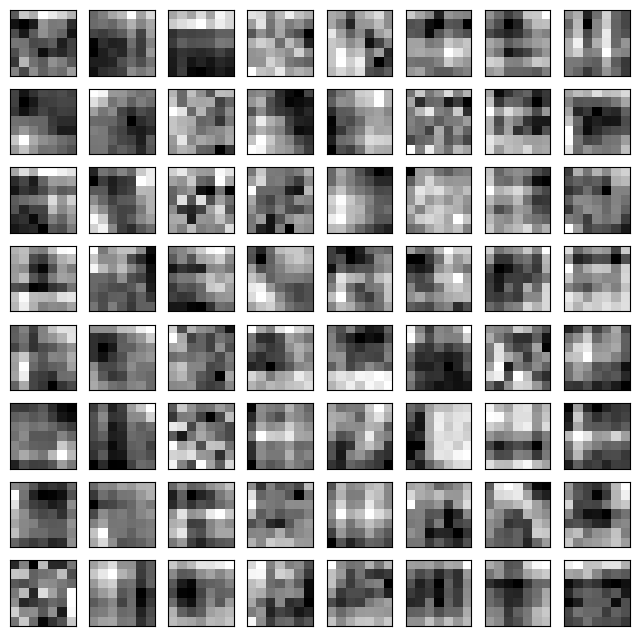

conv2d_1 (3, 3, 64, 64)


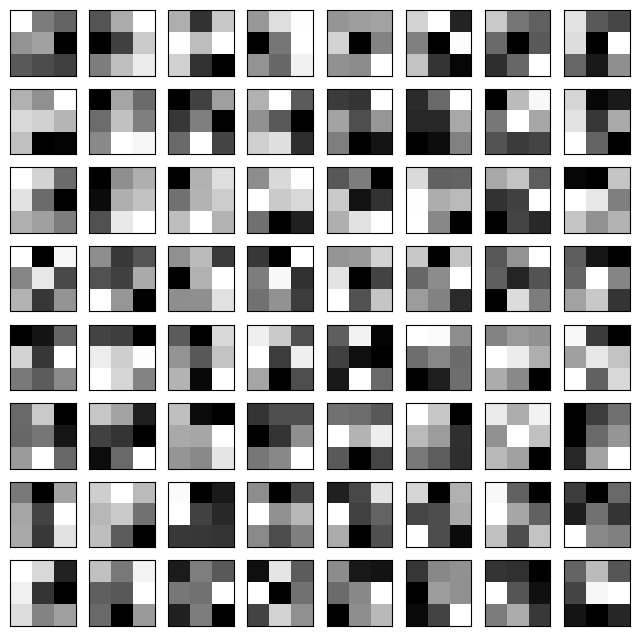

conv2d_2 (3, 3, 64, 64)


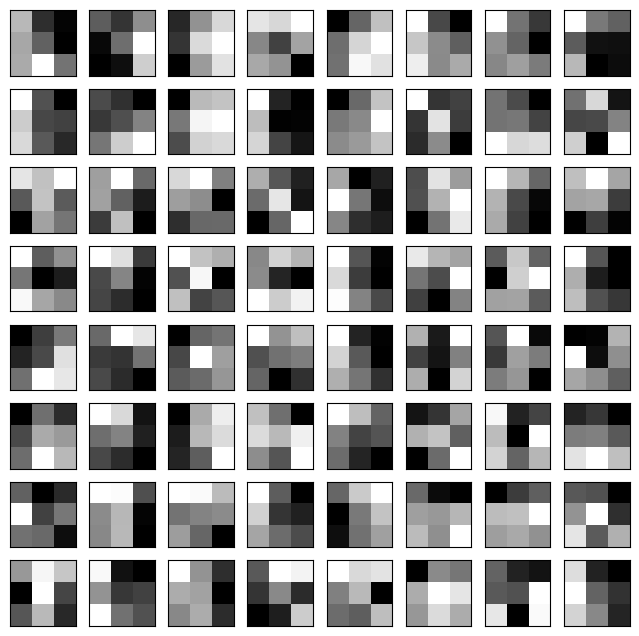

conv2d_3 (3, 3, 64, 64)


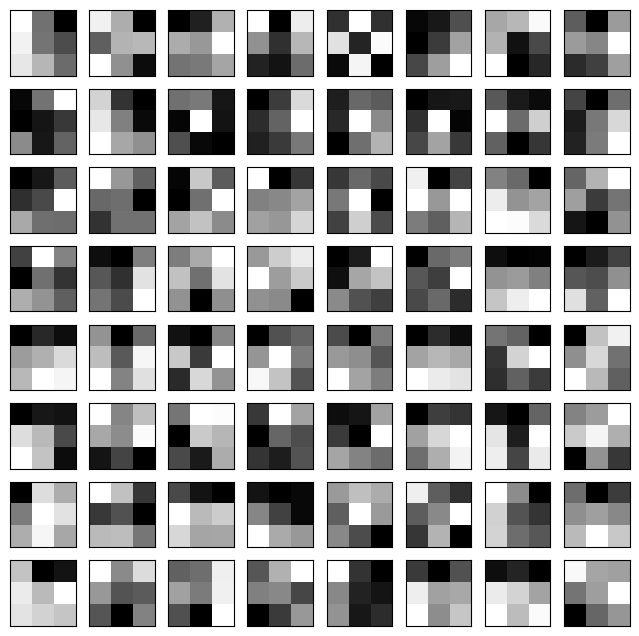

conv2d_4 (3, 3, 64, 64)


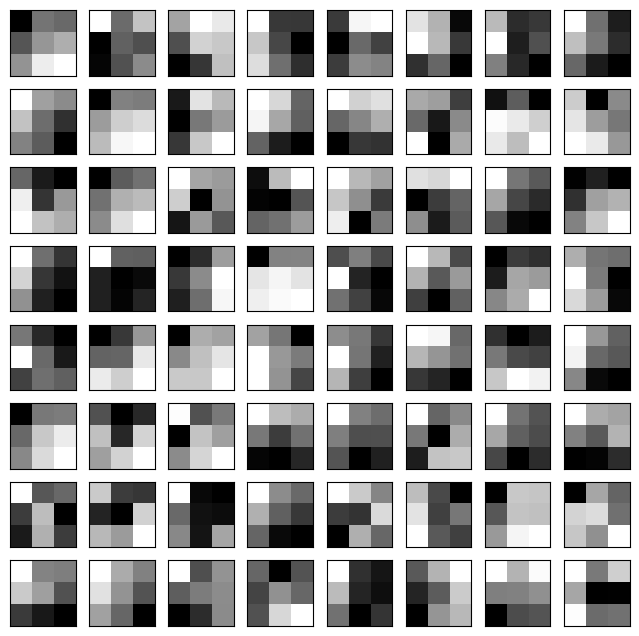

conv2d_5 (3, 3, 64, 128)


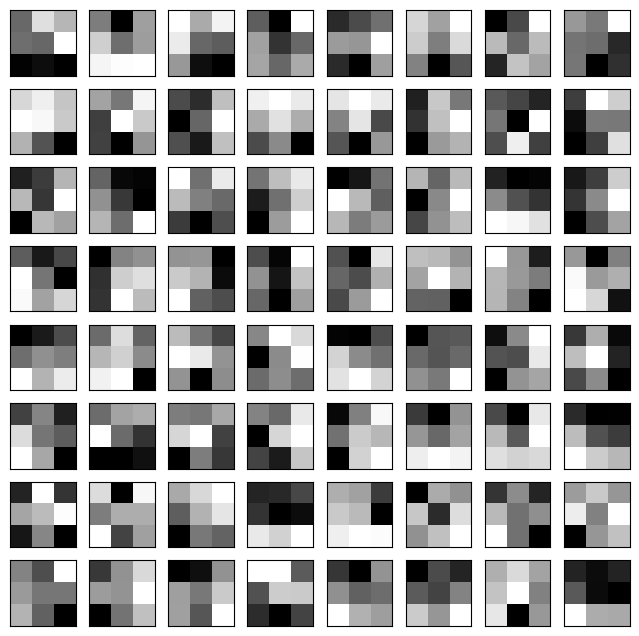

conv2d_6 (3, 3, 128, 128)


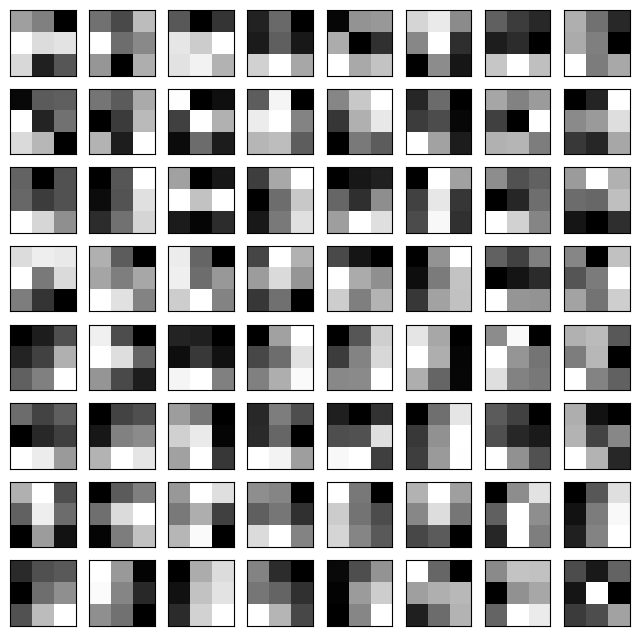

conv2d_7 (1, 1, 64, 128)


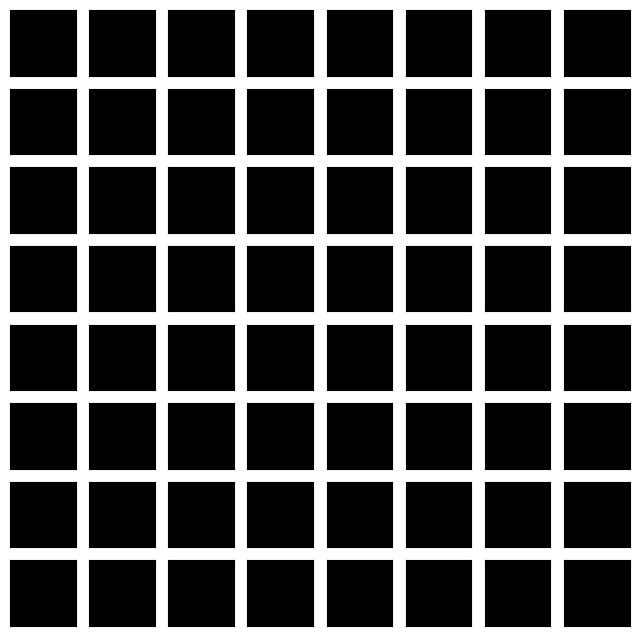

conv2d_8 (3, 3, 128, 128)


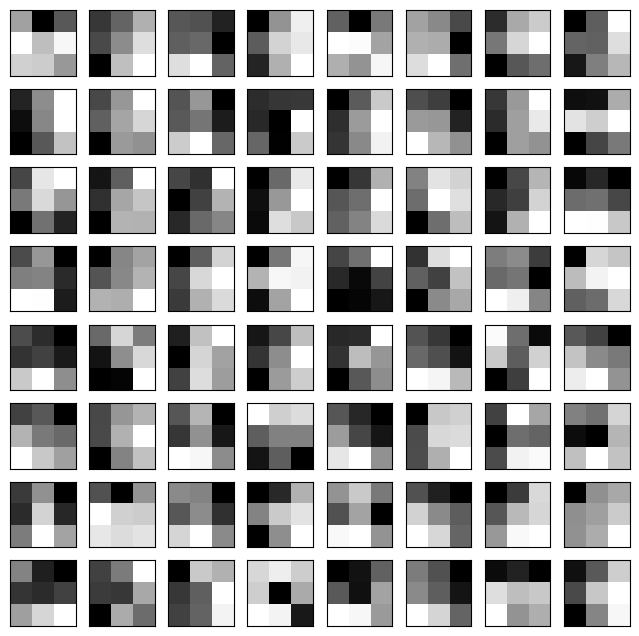

conv2d_9 (3, 3, 128, 128)


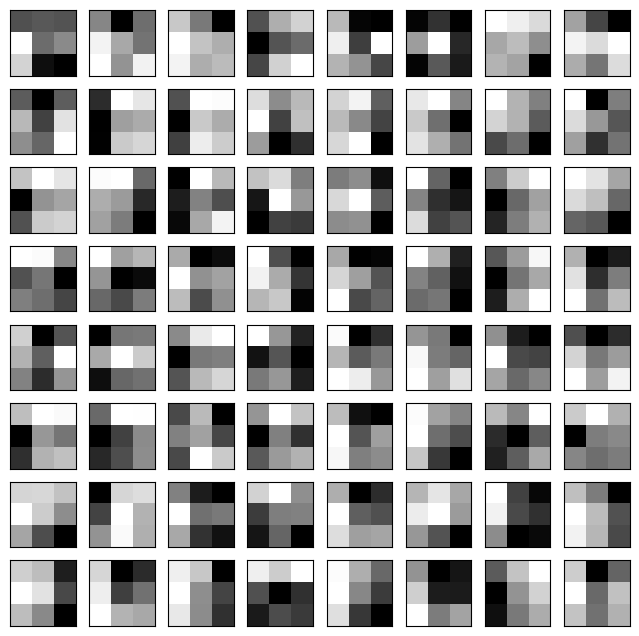

conv2d_10 (3, 3, 128, 256)


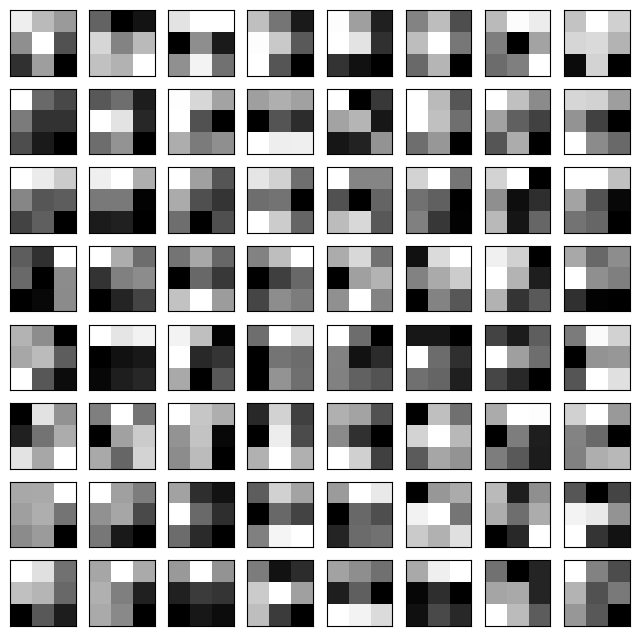

conv2d_11 (3, 3, 256, 256)


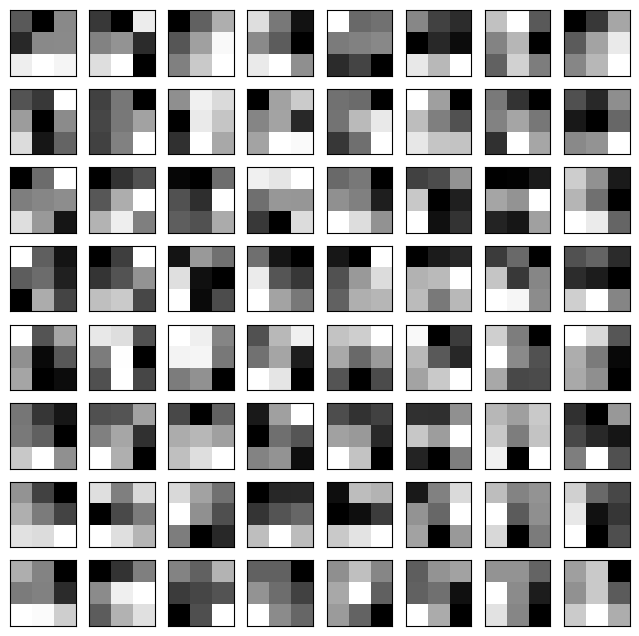

conv2d_12 (1, 1, 128, 256)


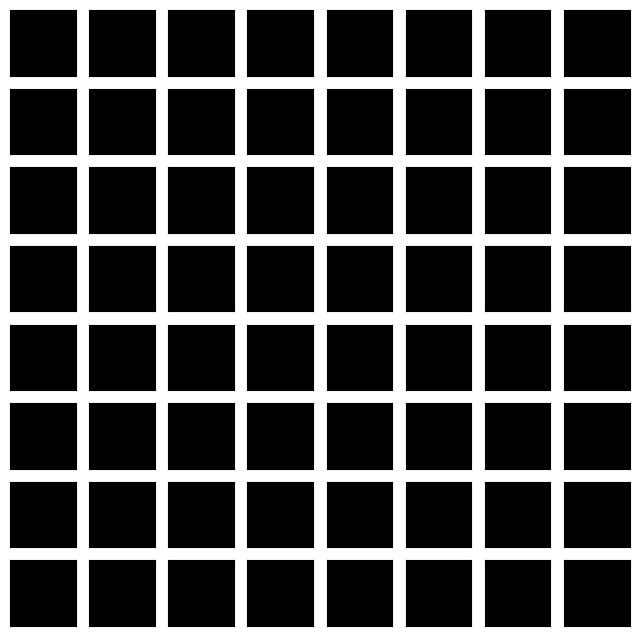

conv2d_13 (3, 3, 256, 256)


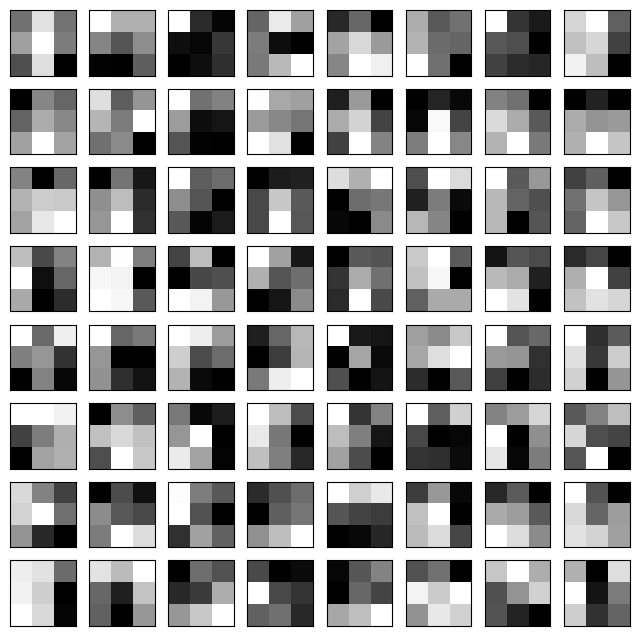

conv2d_14 (3, 3, 256, 256)


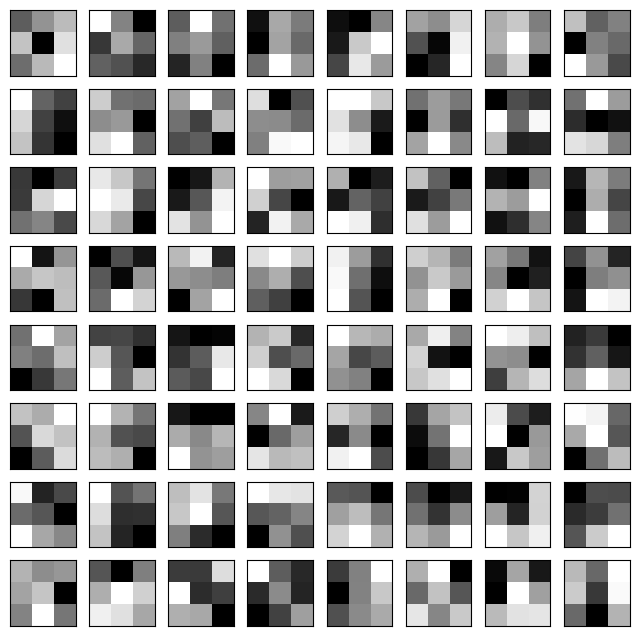

In [ ]:
for index in layer_indices:
    get_filters(index, model_resnet18_new)